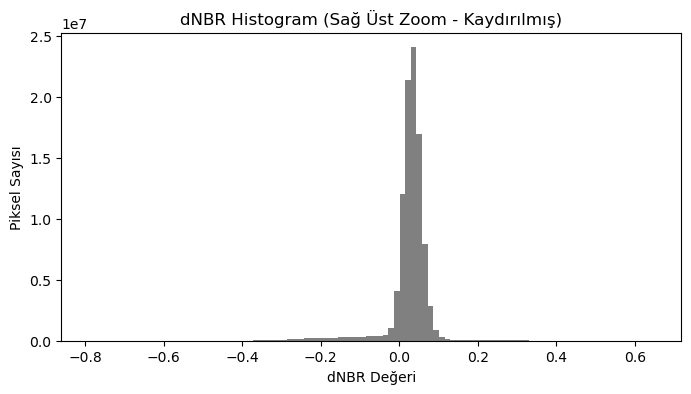

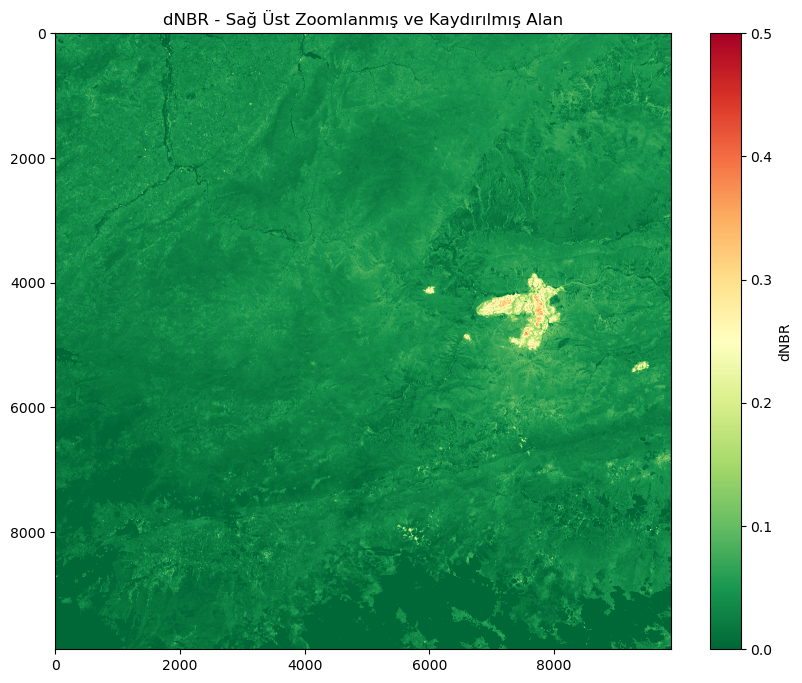

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt


# Dosya yollarını ayarladığımız blok

# 16 Temmuz (yangın öncesi)
red_pre_path = "T36TVL_20250716T084501_B04.jp2"
nir_pre_path = "T36TVL_20250716T084501_B08.jp2"

# 29 Temmuz (yangın sonrası)
red_post_path = "T36TVL_20250729T083559_B04.jp2"
nir_post_path = "T36TVL_20250729T083559_B08.jp2"


# Klasörün içindeki B04 ve B08 dosyalarının okunup NBR değerlerinin alınması

def calculate_nbr(red_path, nir_path):
    with rasterio.open(red_path) as red_src:
        red = red_src.read(1).astype("float32")
        profile = red_src.profile
    with rasterio.open(nir_path) as nir_src:
        nir = nir_src.read(1).astype("float32")
    nbr = (nir - red) / (nir + red)
    nbr = np.nan_to_num(nbr)
    return nbr, profile

nbr_pre, profile = calculate_nbr(red_pre_path, nir_pre_path)
nbr_post, _ = calculate_nbr(red_post_path, nir_post_path)

# dNBR hesaplaması
dnbr = nbr_pre - nbr_post


# 3. Zoomlanmış alanı seçmek için bir blog 
rows, cols = dnbr.shape
zoom_factor = 0.9  # Buradan alanın % kaç zoomlanması isteniyorsa değiştirilebilir.
zoom_height = int(rows * zoom_factor)
zoom_width  = int(cols * zoom_factor)

# Sağ üst köşe, biraz aşağı ve sola kaydır
shift_down = int(rows * 0.05)  # aşağı kaydırma
shift_left = int(cols * 0.05)  # sola kaydırma

start_row = 0 + shift_down
end_row   = start_row + zoom_height
start_col = cols - zoom_width - shift_left
end_col   = start_col + zoom_width

dnbr_zoomed = dnbr[start_row:end_row, start_col:end_col]

#Histogram Oluşturma Bloğu
plt.figure(figsize=(8,4))
plt.hist(dnbr_zoomed.flatten(), bins=100, color='gray')
plt.title("dNBR Histogram (Sağ Üst Zoom - Kaydırılmış)")
plt.xlabel("dNBR Değeri")
plt.ylabel("Piksel Sayısı")
plt.show()

#Görselleştirme Bloğu
plt.figure(figsize=(10,8))
plt.imshow(dnbr_zoomed, cmap='RdYlGn_r', vmin=0.0, vmax=0.5)
plt.colorbar(label='dNBR')
plt.title("dNBR - Sağ Üst Zoomlanmış ve Kaydırılmış Alan")
plt.show()

# İsteğe bağlı olarak dosyayı kaydetmek istersek de burayı çalıştırıyoruz.
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    driver='GTiff'
)
with rasterio.open("dNBR_upper_right_zoom_shifted.tif", "w", **profile) as dst:
    dst.write(dnbr_zoomed, 1)
